In [16]:
pip install datasets scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
from datasets import load_dataset, Dataset
import cv2
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/khanhtl/miniconda3/envs/DL/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def conv2d(image, kernel, stride=1, padding=0):
    """
    Thực hiện tích chập 2D trên ảnh với kernel cho trước.
    """
    img_h, img_w = image.shape
    kernel_h, kernel_w = kernel.shape

    # Thêm padding nếu cần
    padded_image = np.pad(
        image, ((padding, padding), (padding, padding)), mode="constant"
    )

    # Tính kích thước output
    out_h = (img_h + 2 * padding - kernel_h) // stride + 1
    out_w = (img_w + 2 * padding - kernel_w) // stride + 1

    # Khởi tạo output
    output = np.zeros((out_h, out_w))

    # Tích chập
    for i in range(out_h):
        for j in range(out_w):
            region = padded_image[
                i * stride : i * stride + kernel_h,
                j * stride : j * stride + kernel_w,
            ]
            output[i, j] = np.sum(region * kernel)
    return output

In [3]:
def max_pooling(image, size=3, stride=3):
    """
    Thực hiện max pooling trên ảnh.
    """
    img_h, img_w = image.shape
    out_h = (img_h - size) // stride + 1
    out_w = (img_w - size) // stride + 1
    output = np.zeros((out_h, out_w))

    for i in range(out_h):
        for j in range(out_w):
            region = image[
                i * stride : i * stride + size,
                j * stride : j * stride + size,
            ]
            output[i, j] = np.max(region)
    return output

In [4]:
def relu(x):
    return np.maximum(0, x)

In [5]:
def softmax(x):
    x = x - np.max(x, axis=1, keepdims=True)  # Stability improvement
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [6]:
def batchnorm(x):
    mu = np.mean(x, axis=0)
    var = np.var(x, axis=0)
    return (x - mu) / np.sqrt(var + 1e-8)

In [7]:
def fully_connected(x, weights, bias):
    return np.dot(x, weights) + bias

In [8]:
def initialize_weights(filter_size=3):  # FIXED: Không cần tham số input_dim
    # FIXED: Tính toán chính xác kích thước
    input_dim = 10 * 10  # 32x32 -> conv3x3 -> 30x30 -> pool3x3 -> 10x10

    # He initialization
    conv_kernel = np.random.randn(3, 3) * 0.01
    W1 = np.random.randn(input_dim, 128) * np.sqrt(2.0 / input_dim)
    b1 = np.zeros((1, 128))
    W2 = np.random.randn(128, 3) * np.sqrt(2.0 / 128)
    b2 = np.zeros((1, 3))
    return conv_kernel, W1, b1, W2, b2

In [9]:
def pil_to_cv2(image_pil):
    """Convert PIL Image to OpenCV grayscale format"""
    image_np = np.array(image_pil, dtype=np.uint8)

    if len(image_np.shape) == 2:  # Grayscale
        image_resized = cv2.resize(image_np, (32, 32))
        return image_resized / 255.0

    image_resized = cv2.resize(image_np, (32, 32))
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)
    return image_gray / 255.0

In [10]:
def transform_OCR(batch):
    """Convert batch of OCR images from PIL to OpenCV grayscale"""
    batch["array_image"] = [pil_to_cv2(img) for img in batch["image"]]
    batch["labels"] = [1 for _ in batch["image"]]
    return batch

In [11]:
def transform_Cifar10(batch):
    """Convert batch of CIFAR-10 images from PIL to OpenCV grayscale"""
    batch["array_image"] = [pil_to_cv2(img) for img in batch["img"]]
    batch["labels"] = [0 for _ in batch["img"]]
    return batch

In [12]:
def transform_Car_Plate(batch):
    """Convert batch of CIFAR-10 images from PIL to OpenCV grayscale"""
    batch["array_image"] = [pil_to_cv2(img) for img in batch["image"]]
    batch["labels"] = [2 for _ in batch["image"]]
    return batch

In [13]:
def load_data():
    data_OCR = load_dataset("MohamedExperio/ICDAR2019").map(
        transform_OCR, batched=True, batch_size=32
    )
    data_OCR.remove_columns("ground_truth")

    data_Car_plate = load_dataset("AY000554/Car_plate_OCR_dataset")
    data_Car_plate_train = (
        data_Car_plate["train"]
        # .shuffle(seed=42)
        .select(range(450)).map(transform_Car_Plate, batched=True, batch_size=32)
    )
    data_Car_plate_test = (
        data_Car_plate["test"]
        # .shuffle(seed=42)
        .select(range(250)).map(transform_Car_Plate, batched=True, batch_size=32)
    )
    data_Car_plate.remove_columns("image")

    data_Cifar10 = load_dataset("uoft-cs/cifar10").map(
        transform_Cifar10, batched=True, batch_size=32
    )
    data_Cifar10.remove_columns("label")
    data_Cifar10.rename_column("img", "image")

    images_to_train = [x["array_image"] for x in data_OCR["train"]]
    labels_to_train = [x["labels"] for x in data_OCR["train"]]

    for i, x in enumerate(data_Cifar10["train"]):
        if i > 225:
            break
        images_to_train.append(x["array_image"])
        labels_to_train.append(x["labels"])

    for i, x in enumerate(data_Car_plate_train):
        if i > 250:
            break
        images_to_train.append(x["array_image"])
        labels_to_train.append(x["labels"])

    images_to_train = np.array(images_to_train)
    labels_to_train = np.array(labels_to_train)
    shuffle_indices = np.random.permutation(len(images_to_train))
    images_to_train = images_to_train[shuffle_indices]
    labels_to_train = labels_to_train[shuffle_indices]

    images_to_test = [x["array_image"] for x in data_OCR["test"]]
    labels_to_test = [x["labels"] for x in data_OCR["test"]]

    for i, x in enumerate(data_Cifar10["test"]):
        if i > 125:
            break
        images_to_test.append(x["array_image"])
        labels_to_test.append(x["labels"])

    for i, x in enumerate(data_Car_plate_test):
        if i > 100:
            break
        images_to_test.append(x["array_image"])
        labels_to_test.append(x["labels"])

    train_dataset = Dataset.from_dict(
        {"image": images_to_train, "labels": labels_to_train}
    )
    train_val_split = train_dataset.train_test_split(test_size=0.2, seed=42)

    testloadder = Dataset.from_dict({"image": images_to_test, "labels": labels_to_test})

    return train_val_split["train"], train_val_split["test"], testloadder

In [14]:
def forward_propagation(x, params):
    conv_kernel_1, W1, b1, W2, b2 = params
    x_reshaped = np.array(x).reshape(-1, 32, 32)

    # Convolution + ReLU + Max Pooling
    conv_output_1 = np.array(
        [conv2d(img, conv_kernel_1) for img in x_reshaped]
    )  # 30x30

    conv_output_relu_1 = relu(conv_output_1)

    pooled_output_1 = np.array(
        [max_pooling(img) for img in conv_output_relu_1]
    )  # 10 x 10

    # Flatten
    flattened = np.array(pooled_output_1).reshape(len(x), -1)

    # Fully Connected Layers
    z1 = fully_connected(flattened, W1, b1)
    a1 = relu(z1)
    z2 = fully_connected(a1, W2, b2)
    a2 = softmax(z2)

    return (
        conv_output_1,
        pooled_output_1,
        z1,
        a1,
        z2,
        a2,
        flattened,
    )

100%|██████████| 100/100 [04:41<00:00,  2.81s/it]


Test Accuracy: 82.15%


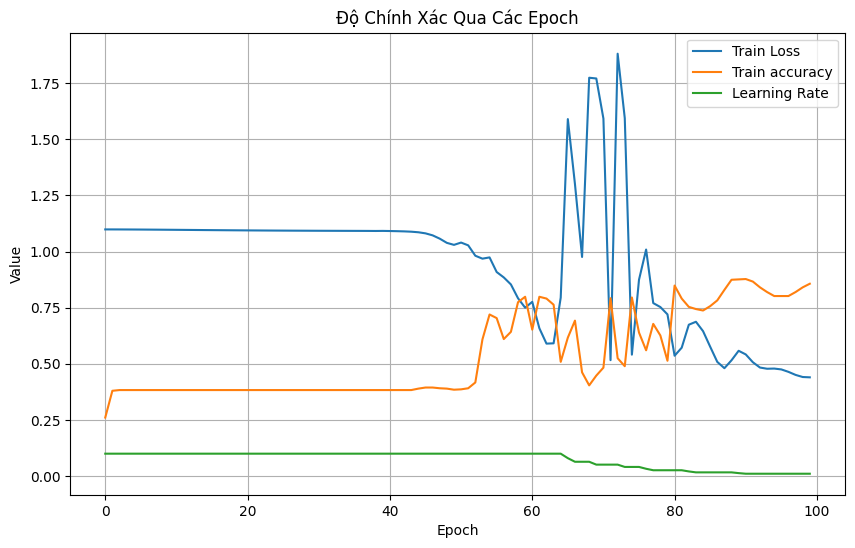

In [17]:
if __name__ == "__main__":
    trainloadder, valloadder, testloadder = load_data()

    # train_model(trainloadder, valloadder, testloadder)
    # One-hot encode labels
    encoder = OneHotEncoder(sparse_output=False)
    y_train = encoder.fit_transform(np.array(trainloadder["labels"]).reshape(-1, 1))
    y_val = encoder.transform(np.array(valloadder["labels"]).reshape(-1, 1))
    y_test = encoder.transform(np.array(testloadder["labels"]).reshape(-1, 1))
    epochs = 100
    learning_rate = 0.1  # Giảm từ 0.1 -> 0.01
    momentum = 0.9  # Tăng momentum
    max_grad_norm = 1.0  # Thêm gradient clipping

    history_loss = []
    history_accuracy = []
    history_lr = []

    # FIXED: Khởi tạo weights mới
    conv_kernel_1, W1, b1, W2, b2 = initialize_weights(3)
    params = (conv_kernel_1, W1, b1, W2, b2)
    v_conv_kernel_1, v_W1, v_b1, v_W2, v_b2 = [
        np.zeros_like(param) for param in params
    ]
    for epoch in tqdm(range(epochs)):
        history_lr.append(learning_rate)
        (
            conv_output_1,
            pooled_output_1,
            z1,
            a1,
            z2,
            a2,
            flattened,
        ) = forward_propagation(trainloadder["image"], params)
        loss = -np.mean(np.sum(y_train * np.log(a2 + 1e-8), axis=1))
        history_loss.append(loss)
        # print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

        predictions = np.argmax(a2, axis=1)
        accuracy = np.mean(predictions == np.argmax(y_train, axis=1))
        history_accuracy.append(accuracy)

        m = len(trainloadder["image"])
        dz2 = a2 - y_train
        dW2 = np.dot(a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        da1 = np.dot(dz2, W2.T)
        dz1 = da1 * (z1 > 0)
        dW1 = np.dot(flattened.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        # Compute convolutional layer gradients using stride tricks
        images_np = np.array(trainloadder["image"])
        dpool = np.dot(dz1, W1.T).reshape(m, 10, 10)
        # Sửa phần tính gradient conv
        dconv = np.zeros_like(conv_kernel_1)
        relu_mask = (conv_output_1 > 0).astype(float)
        # Thêm phần upsampling gradient cho pooling layer
        def unpool(grad_pool, original_size=(30, 30), pool_size=3):
            grad = np.zeros(
                (grad_pool.shape[0], original_size[0], original_size[1])
            )
            for i in range(grad_pool.shape[1]):
                for j in range(grad_pool.shape[2]):
                    grad[
                        :,
                        i * pool_size : (i + 1) * pool_size,
                        j * pool_size : (j + 1) * pool_size,
                    ] = grad_pool[:, i : i + 1, j : j + 1]
            return grad
        dpool_upsampled = unpool(
            dpool, original_size=(30, 30)
        )  # Chuyển từ 10x10 -> 30x30
        for i in range(3):
            for j in range(3):
                input_patches = images_np[:, i : i + 30, j : j + 30]
                grad_patches = dpool_upsampled * relu_mask  # Nhân với mask ReLU
                dconv[i, j] = np.sum(input_patches * grad_patches) / m
        # FIXED: Thêm gradient clipping
        for grad in [dW1, db1, dW2, db2, dconv]:
            np.clip(grad, -max_grad_norm, max_grad_norm, out=grad)
        # Momentum update
        v_W1 = momentum * v_W1 + (1 - momentum) * dW1
        v_b1 = momentum * v_b1 + (1 - momentum) * db1
        v_W2 = momentum * v_W2 + (1 - momentum) * dW2
        v_b2 = momentum * v_b2 + (1 - momentum) * db2
        v_conv_kernel_1 = momentum * v_conv_kernel_1 + (1 - momentum) * dconv
        # Update parameters
        W1 -= learning_rate * v_W1
        b1 -= learning_rate * v_b1
        W2 -= learning_rate * v_W2
        b2 -= learning_rate * v_b2
        conv_kernel_1 -= learning_rate * v_conv_kernel_1
        if epoch > 10 and loss > prev_loss * 1.05:
            learning_rate *= 0.8
        prev_loss = loss
    _, _, _, _, _, a2_test, _ = forward_propagation(testloadder["image"], params)
    predictions = np.argmax(a2_test, axis=1)
    accuracy = np.mean(predictions == np.argmax(y_test, axis=1))
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    # Accuracy curve data
    epochs = np.arange(0, 100)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history_loss, label="Train Loss")
    plt.plot(epochs, history_accuracy, label="Train accuracy")
    plt.plot(epochs, history_lr, label="Learning Rate")
    plt.title("Độ Chính Xác Qua Các Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.savefig("accuracy_curve.png", dpi=300)